In [107]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import model_selection
import math

%matplotlib inline
plt.style.use('seaborn-white')

# Lasso Overview

Least Absolute Shrinkage and Selection Operator

Objective Function:

Derivation of Coordinate descent for Lasso Regression

$$ \begin{eqnarray}
\underset{\beta}{\mathrm{argmin}} RSS_{lasso} (\beta) &=& \frac{1}{2}RSS_{OLS} (\beta) + \lambda |\beta|_{1}\\
&=& \underset{\beta}{\mathrm{argmin}} \frac{1}{2} ||y - (\beta)X)||^{2}_{2} + \lambda |\beta|_{1} \\ 
&=& f(\beta) + g(\beta)
\end{eqnarray}$$

where A is the $RSS_{OLS}$ term, and B is the regularization factor for Lasso.

We isolate the $\beta_{j}$ via 

where,
$f(\beta)$ = $\frac{1}{2} ||y - (\beta)'X)||^{2}_{2}$ is the $RSS_{OLS}$
$g(\beta)$ = $\lambda |\beta|_{1}$ is the regularization factor.
Note: Regularization factor means that the new loss function (error of the fit) penalizes if $\beta$ has too large a variance/deviation. 

After applying some subdifferentials and subderivatives, we find that the Objective function becomes: 

$RSS_{Lasso}(\beta) = RSS_{OLS}(\beta) + \lambda ||\beta||_{1}$

$$ \begin{eqnarray}
\frac{\partial d}{\partial d\beta_{j}} RSS_{Lasso} + \partial \beta_{j} \lambda \sum^{n}_{j=0} |\beta_{j}| \\
&=& - \sum^{m}_{i=0} x_{j}^{(i)} [y^{(i)} - \sum^{n}_{k \ne j} \theta_{k}x_{k}^{(i)}] + \theta_{j} \sum^{m}_{i=1}(x_{j}^{(i)})^{2} + \partial_{\beta_{j} \lambda|\beta_{j}| \\ 
&=& - \rho_{j} +  \beta_{j}z + \partial_{\beta_{j} \lambda|\beta_{j}| \\ 
\end{eqnarray}$$


SR3: Sparse Relaxed Regularized Regression 
    - Better numerical properties. Relaxed coordinates.

Proposed strategy:
- Use Soft-thresholding operator using coordinate descent algorithms
- Tuning lambda:
    - Define a range of lambda values.
    - Bootstrap sets of size math.ceil(n/k). 
    - For each lambda value k, train lasso model on all sets.
    - Obtain MSE of lasso models for all sets with lambda = k.
    - Find mean MSE for each lambda=k.
    - Find lambda value with minimum mean MSE.

Notes on Lasso:

Video 2: Steve Brunton from UW

- For variable selection and getting interpretable regression models that don't overfit to data.
- Feature selection: 
    - LASSO can provide a sparse solution $\overrightarrow{\beta}$-- hence feature selection.

- Attributes:
    - Interpretability:
        - OLS is not interpretable because all variables are considered important. OLS selects important variables.
        - Lower dimensional models (if similarly good at minimizing error), is easier to interpret, communicate and make decisions. (principle of parsimony).
    - Prevents overfitting:
        - OLS: x coefficients may overfit A to data in b. (modelling noise and reducing generalizability)
        - When $\lambda$ increases past $\lambda_{lasso}$, MSE starts increasing again because we are adding in terms that are collinear and not actually correlated with response variable. 
    - Multicollinearity:
        - When variables are collinear, OLS amplifies noise in response vector (nearly linearly dependent).

- Geometric Visualization:
    - L1 norm intersects space of all possible solutions at a sparse solution. L1 norm intersects at a dense solution. 

### Lasso from scratch begins here: 

1. The setup: design matrix and response variable (price).
2. Two functions: soft_thresholding and coordinate_descent_lasso are created. 
    - soft_thresholding: returns value of objective function based on values of rho and lamda.
    - coordinate_descent_lasso: returns 
We use a coordinate descent algorithm to solve the lasso regression problem.

In [54]:
#Loading in Data
df = pd.read_csv("../data/listings.csv")

In [81]:
X_df = df[
    [
        "host_id",
        "latitude",
        "longitude",
        "minimum_nights",
        "number_of_reviews",
        "reviews_per_month",
        "calculated_host_listings_count",
        "availability_365"
    ]
]
y_df = df[["price"]]
X = X_df.to_numpy()
y = y_df.to_numpy()
y = y.reshape(-1,1)

In [56]:
def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

In [57]:
def coordinate_descent_lasso(theta,X,y,lamda = .01, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ theta
            rho = X_j.T @ (y - y_pred  + theta[j]*X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                theta[j] =  soft_threshold(rho, lamda)   
            
    return theta.flatten()

In [58]:
cols = list(X_df.columns)
cols

['host_id',
 'latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

(0.06309573444801933,
 1584.893192461114,
 -29381.889752738287,
 29176.20400648511)

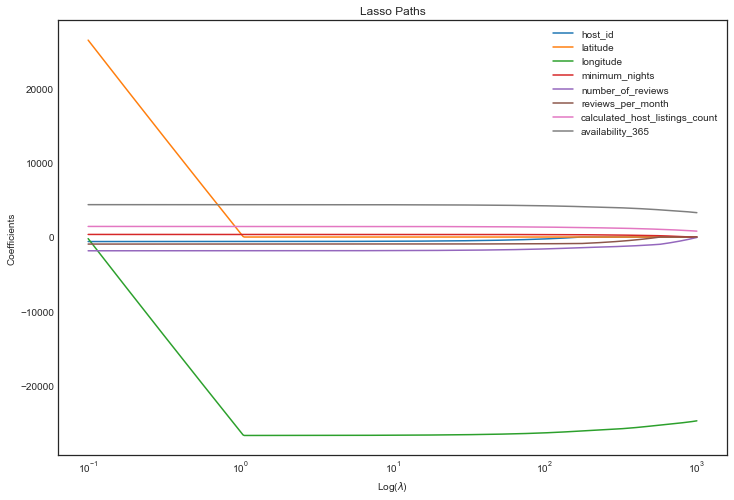

In [59]:
# Initialize variables
m,n = X.shape
initial_theta = np.ones((n,1))
theta_list = list()
lamda = np.logspace(0,4,500)/10 #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    theta = coordinate_descent_lasso(initial_theta,X,y,lamda = l, num_iters=100)
    theta_list.append(theta)

#Stack into numpy array
theta_lasso = np.stack(theta_list).T

#Plot results
n,_ = theta_lasso.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, theta_lasso[i], label = cols[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend()
plt.axis('tight')

In [120]:
np.shape(theta_lasso)

(8, 500)

In [67]:
print(np.shape(X))
print(np.shape(y))

(38837, 8)
(38837, 1)


In [95]:
new_df = df[[
    "host_id",
    "latitude",
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "price"]]

In [106]:
np.shape(new_df)

(38837, 9)

In [114]:
# Bootstrapping 10 sets of observations. 

def bootstrap(n,p,k,df,response_name,design_names):
    '''
    n: number of observations
    p: dimensionality of each observation
    k: number of random splits to generate (with resampling)
    df: pandas dataframe containing design matrix and response variable values.
    response_name: name (string) of response variable. 
    design_names: list of strings that are predictor variable names.
    
    Returns 
        sample_X (dim: k x n x (p-1)) design matrix of k resampled sets.
        sample_y (dim: k x n x 1) numpy array of response values of k resampled sets
    '''
    sample_X = np.empty(shape=(k,math.ceil(n/k),p-1)) 
    sample_y = np.empty(shape=(k,math.ceil(n/k),1)) 
    for i in range(k):
        split = df.sample(frac=1/k,random_state=200)
        split_X = split[design_names] 
        split_y = split[[response_name]]
        sample_X[i] = split_X.to_numpy()
        sample_y[i] = split_y.to_numpy()
        
    return sample_X,sample_y

In [115]:
design_names = [
    "host_id",
    "latitude",
    "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"]
response_name = "price"
sample_X,sample_y = bootstrap(38837,9,10,new_df,response_name,design_names)

In [ ]:
# In progress

# Finding MSE of the k models for each lambda value.

theta_list = np.empty(shape=(10,8,1))
MSE = np.empty(shape=(500,10,1))

for i in range(10):
    
    m,n = sample_X[i].shape
    initial_theta = np.ones((n,1))
    lamda = np.logspace(0,4,500)/10 # Range of lambda values

    #Run lasso regression for each lambda
    for l in lamda:
        theta = coordinate_descent_lasso(initial_theta,sample_X[i],sample_y[i],lamda = l, num_iters=100)
        y_hat[i] = sample_X@theta
        MSE += (y[i] - y_hat[i])^2
    MSE[i] = MSE[i]/n
        